<a href="https://colab.research.google.com/github/ehdgml1/Credit-Card-Fraud-Prediction/blob/main/%EC%8B%A0%EC%9A%A9%EC%B9%B4%EB%93%9C_%EC%82%AC%EA%B8%B0%EA%B1%B0%EB%9E%98_%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 사용한 기술들
1. python ,pandas, numpy, matplotlib, seaborn 
2. sklearn(LabelEncoder, RandomForestClassifier)



In [ ]:
# ▶ Warnings 제거
import warnings
warnings.filterwarnings('ignore')

# ▶ Google drive mount or 폴더 클릭 후 구글드라이브 연결
from google.colab import drive
drive.mount('/content/drive')

# ▶ 경로 설정 (※ Colab을 활성화시켰다면 보통 Colab Notebooks 폴더가 자동 생성)
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/')
os.getcwd()

Mounted at /content/drive


'/content/drive/MyDrive/Colab Notebooks'

In [ ]:
import numpy as np
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/data 모음/credit_fraud.csv')

## 가상 문제상황 정의

최근 금융사 A는 비트코인 열풍으로 수수료 거래 금액이 늘어 좋으면서도 한편으로는 골치를 썩고있다.  그 이유는 바로 사기거래 때문이다. 사기거래의 횟수도 증가하며 Claim을 넣는 고객들도 늘어나고 있다 이에 A사는 사기거래로 예측되는 거래건에 경우 거래를 제한하려고 한다.

## 데이터 살펴보기

## 컬럼별 뜻

|account_age_days| transaction_amt| transaction_adj_amt|historic_velocity|ip_address|user_agent|email_domain|phone_number|billing_city|billing_postal|
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
|계좌 생성후 지난일|거래금액|거래 조정 금액|과거 거래금액|IP주소|사용환경|email 도메인|전화번호|청구도시|청구우편번호
|billing_state|card_bin|currency|cvv|signature_image|transaction_type|transaction_env|EVENT_TIMESTAMP|applicant_name|billing_address|
|청구주|카드bin번호(앞6자리)|통화|CVV|서명이미지|거래종류|거래환경|거래일자|신청자 이름|청구주소|
|merchant_id|locale|tranaction_initiate|days_since_last_logon|inital_amount|EVENT_LABEL|
|상점ID|지역|거래초기코드|마지막로그인후경과일|초기잔액|사기여부|

In [ ]:
df.head()

,account_age_days,transaction_amt,transaction_adj_amt,historic_velocity,ip_address,user_agent,email_domain,phone_number,billing_city,billing_postal,...,transaction_env,EVENT_TIMESTAMP,applicant_name,billing_address,merchant_id,locale,tranaction_initiate,days_since_last_logon,inital_amount,EVENT_LABEL
0,3371.0,2167.0,56.0,2572.0,154.68.49.124,Opera/9.81.(Windows NT 10.0; ht-HT) Presto/2.9...,perez-garza.com,878-111-5140,Woodsburgh,96336.0,...,X,2020-12-29 09:05:51,Linda Wright,4684 Sharon Ranch,066-82-8795,niu_NZ,O,59.0,13646.0,legit
1,2714.0,2045.0,48.0,4517.0,39.131.125.85,Opera/9.76.(X11; Linux i686; mi-NZ) Presto/2.9...,mcneil-ortega.com,(002)736-0139,West Kevin,78083.0,...,W,2021-06-22 18:05:06,Terri Rivera,7642 Allison Ramp,669-99-9459,apn_IN,J,0.0,11930.0,legit
2,6987.0,2892.0,61.0,5007.0,166.245.194.83,Mozilla/5.0 (X11; Linux x86_64; rv:1.9.6.20) G...,davis-calderon.com,(983)585-2863x652,Lorichester,83236.0,...,X,2021-05-10 13:48:38,Sarah Gray,4948 Lisa Passage,086-41-1624,dv_MV,T,83.0,7412.0,legit
3,2712.0,3040.0,28.0,6022.0,100.1.217.216,Mozilla/5.0 (Macintosh; Intel Mac OS X 10 9_3 ...,rose-lee.org,+1-678-897-3420x60738,Stephenmouth,78364.0,...,N,2021-03-11 07:36:40,Valerie Jenkins,1616 Little Camp,669-97-4021,byn_ER,M,24.0,4623.0,legit
4,3598.0,2976.0,66.0,2600.0,113.156.65.245,Mozilla/5.0 (X11; Linux x86_64; rv:1.9.5.20) G...,nash.net,(013)204-1766x92641,New Brianmouth,77499.0,...,G,2021-03-27 06:13:35,Amy Coleman,149 Harris Rapid,088-21-6329,the_NP,K,21.0,1905.0,legit


# **문제 해결 프로세스 정의**

## **문제 정의**

사기거래로 인한 고객 Claim증가, 브랜드 이미지 감소, 고객 탈퇴

### **기대효과**
사기거래 거래 제한으로 고객 Claim감소, 브랜드 이밎 회복, 고객방어

### **성과 측정**
모델 적용 전과 후를 비교해 사기거래의 Claim감소 건수 확인 가능

### **현업 적용 과정**
1. 카드 Spending data 실시간으로 수집

2. 거래 발생시 마다 모든 거래에 대해 Data모델 Input후 사기거래 의심 건수 추출

3. 사기 거래 가능성이 높은 거래 건수에 대해 제한 조치 실행

In [ ]:
df.shape

(150000, 26)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 26 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   account_age_days       149892 non-null  float64
 1   transaction_amt        149870 non-null  float64
 2   transaction_adj_amt    149886 non-null  float64
 3   historic_velocity      149885 non-null  float64
 4   ip_address             149873 non-null  object 
 5   user_agent             149887 non-null  object 
 6   email_domain           149910 non-null  object 
 7   phone_number           149873 non-null  object 
 8   billing_city           149884 non-null  object 
 9   billing_postal         149876 non-null  float64
 10  billing_state          149887 non-null  object 
 11  card_bin               149872 non-null  float64
 12  currency               149892 non-null  object 
 13  cvv                    149877 non-null  object 
 14  signature_image        149895 non-nu

In [ ]:
df.isnull().sum()

account_age_days         108
transaction_amt          130
transaction_adj_amt      114
historic_velocity        115
ip_address               127
user_agent               113
email_domain              90
phone_number             127
billing_city             116
billing_postal           124
billing_state            113
card_bin                 128
currency                 108
cvv                      123
signature_image          105
transaction_type         116
transaction_env          123
EVENT_TIMESTAMP          112
applicant_name           143
billing_address          134
merchant_id              107
locale                   134
tranaction_initiate      126
days_since_last_logon    136
inital_amount            128
EVENT_LABEL                0
dtype: int64

In [ ]:
#결측치의 데이터가 작아서 삭제해도 될듯함
df = df.dropna(axis=0)

In [ ]:
df.shape
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 147000 entries, 0 to 149999
Data columns (total 26 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   account_age_days       147000 non-null  float64
 1   transaction_amt        147000 non-null  float64
 2   transaction_adj_amt    147000 non-null  float64
 3   historic_velocity      147000 non-null  float64
 4   ip_address             147000 non-null  object 
 5   user_agent             147000 non-null  object 
 6   email_domain           147000 non-null  object 
 7   phone_number           147000 non-null  object 
 8   billing_city           147000 non-null  object 
 9   billing_postal         147000 non-null  float64
 10  billing_state          147000 non-null  object 
 11  card_bin               147000 non-null  float64
 12  currency               147000 non-null  object 
 13  cvv                    147000 non-null  object 
 14  signature_image        147000 non-nu

In [ ]:
df.describe()

,account_age_days,transaction_amt,transaction_adj_amt,historic_velocity,billing_postal,card_bin,days_since_last_logon,inital_amount
count,147000.000000,147000.000000,147000.000000,147000.000000,147000.000000,147000.000000,147000.000000,147000.000000
mean,4645.817224,2521.343592,54.208837,4702.388673,50179.458129,41834.312320,49.858524,7996.856367
std,1153.792072,604.680167,10.068128,1188.255402,28389.219411,10082.094148,29.208844,4047.922681
min,1.000000,5.000000,1.000000,50.000000,503.000000,6040.000000,0.000000,1000.000000
25%,3824.000000,2103.000000,48.000000,3872.000000,25298.000000,35386.000000,24.000000,4485.000000
50%,4668.000000,2543.000000,55.000000,4729.000000,50072.000000,42086.000000,50.000000,7999.000000
75%,5476.000000,2951.000000,61.000000,5548.000000,74346.000000,47373.000000,75.000000,11495.000000
max,9119.000000,4999.000000,99.000000,9999.000000,99950.000000,67639.000000,100.000000,15000.000000


In [ ]:
# target에 대한 정보를 보기 편하게 사기거래는 1 아닌 것은 0으로 변경
df['EVENT_LABEL'] = np.where(df['EVENT_LABEL'] == 'fraud' , 1,0)

In [ ]:
df['EVENT_LABEL'].value_counts()

0    138996
1      8004
Name: EVENT_LABEL, dtype: int64

5%정도의 사기 거래율을 나타냄


In [ ]:
df['user_agent'].head(1)

0    Opera/9.81.(Windows NT 10.0; ht-HT) Presto/2.9...
Name: user_agent, dtype: object

lambda식을 활용해 고객 사용환경의 값들중 앞부분의 값들만 따와 보겟습니다.

In [ ]:
df['user_agent'] = df['user_agent'].apply(lambda x : x.split('/')[0])

In [ ]:
df.head(3)

,account_age_days,transaction_amt,transaction_adj_amt,historic_velocity,ip_address,user_agent,email_domain,phone_number,billing_city,billing_postal,...,transaction_env,EVENT_TIMESTAMP,applicant_name,billing_address,merchant_id,locale,tranaction_initiate,days_since_last_logon,inital_amount,EVENT_LABEL
0,3371.0,2167.0,56.0,2572.0,154.68.49.124,Opera,perez-garza.com,878-111-5140,Woodsburgh,96336.0,...,X,2020-12-29 09:05:51,Linda Wright,4684 Sharon Ranch,066-82-8795,niu_NZ,O,59.0,13646.0,0
1,2714.0,2045.0,48.0,4517.0,39.131.125.85,Opera,mcneil-ortega.com,(002)736-0139,West Kevin,78083.0,...,W,2021-06-22 18:05:06,Terri Rivera,7642 Allison Ramp,669-99-9459,apn_IN,J,0.0,11930.0,0
2,6987.0,2892.0,61.0,5007.0,166.245.194.83,Mozilla,davis-calderon.com,(983)585-2863x652,Lorichester,83236.0,...,X,2021-05-10 13:48:38,Sarah Gray,4948 Lisa Passage,086-41-1624,dv_MV,T,83.0,7412.0,0


## 의미있는 변수 선택
- 의미있는 변수란
- 해당변수에 의해서 예측하고자 하는 데이터가 잘 구분 되어지는 변수
## Numeric 변수
연속형 변수는 구간화를 통해 범주형 변수로 변경하고, 잘 구분 되어지는지 확인
## Categorical변수
각 그룹별 예측하고자 하는 데이터가 잘 나눠지는지 확인

In [ ]:
# 범주형 변수와 숫자형 변수 나누기
numeric_list=[]
categoical_list=[]

for i in df.columns :
  if df[i].dtypes == 'O' :
    categoical_list.append(i)
  else :
    numeric_list.append(i)

print("categoical_list :", categoical_list)
print("numeric_list :", numeric_list)

categoical_list : ['ip_address', 'user_agent', 'email_domain', 'phone_number', 'billing_city', 'billing_state', 'currency', 'cvv', 'signature_image', 'transaction_type', 'transaction_env', 'EVENT_TIMESTAMP', 'applicant_name', 'billing_address', 'merchant_id', 'locale', 'tranaction_initiate']
numeric_list : ['account_age_days', 'transaction_amt', 'transaction_adj_amt', 'historic_velocity', 'billing_postal', 'card_bin', 'days_since_last_logon', 'inital_amount', 'EVENT_LABEL']


In [ ]:
#숫자형 변수이름 뽑아보기
print("numeric_list :", numeric_list)

numeric_list : ['account_age_days', 'transaction_amt', 'transaction_adj_amt', 'historic_velocity', 'billing_postal', 'card_bin', 'days_since_last_logon', 'inital_amount', 'EVENT_LABEL']


In [ ]:
#숫자형 변수만 뽑아보기
df[numeric_list]

,account_age_days,transaction_amt,transaction_adj_amt,historic_velocity,billing_postal,card_bin,days_since_last_logon,inital_amount,EVENT_LABEL
0,3371.0,2167.0,56.0,2572.0,96336.0,40771.0,59.0,13646.0,0
1,2714.0,2045.0,48.0,4517.0,78083.0,24480.0,0.0,11930.0,0
2,6987.0,2892.0,61.0,5007.0,83236.0,37778.0,83.0,7412.0,0
3,2712.0,3040.0,28.0,6022.0,78364.0,55790.0,24.0,4623.0,0
4,3598.0,2976.0,66.0,2600.0,77499.0,37370.0,21.0,1905.0,0
...,...,...,...,...,...,...,...,...,...
149995,3986.0,2890.0,57.0,4544.0,34817.0,30017.0,99.0,6681.0,0
149996,5834.0,1875.0,61.0,4369.0,35879.0,65507.0,85.0,2402.0,0
149997,4781.0,3371.0,48.0,5135.0,84167.0,47079.0,22.0,4113.0,0
149998,6085.0,2306.0,59.0,4846.0,80391.0,25891.0,70.0,4531.0,0


<AxesSubplot:xlabel='transaction_amt', ylabel='Density'>

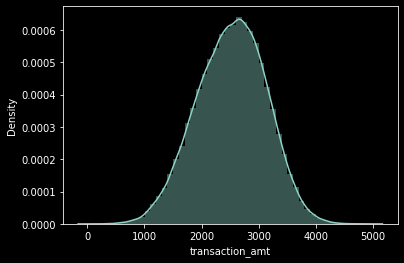

In [ ]:
#시각화를 통해 거래금액(transaction_amt)에 대한 분포 확인
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use(['dark_background'])
sns.distplot(df['transaction_amt'])

In [ ]:
# 구간화를 통해 유의미한 insight창출
import numpy as np
df['transaction_amt_gp'] = np.where(df['transaction_amt'] <=2000,1,np.where(df['transaction_amt'] <=3000,2,3))

df[['transaction_amt','transaction_amt_gp']]

,transaction_amt,transaction_amt_gp
0,2167.0,2
1,2045.0,2
2,2892.0,2
3,3040.0,3
4,2976.0,2
...,...,...
149995,2890.0,2
149996,1875.0,1
149997,3371.0,3
149998,2306.0,2


In [ ]:
#구간화에 따른 사기거래
df.groupby(['transaction_amt_gp','EVENT_LABEL'])['transaction_amt'].count()

transaction_amt_gp  EVENT_LABEL
1                   0              29420
                    1                353
2                   0              79588
                    1               4825
3                   0              29988
                    1               2826
Name: transaction_amt, dtype: int64

In [ ]:
# 그룹에 따라 사기거래률이 적절하게 나누어 졌다고 볼수 있음
# 3번 그룹의 사기거래율이 높다 보통 가격이 높을수록 사기의 빈도수가 늘어나는듯?!?
print("group1 :", (353 / (353+29420))*100)
print("group2 :", (4825 / (4825+79588))*100)
print("group3 :", (2826 / (2826+29988))*100)

group1 : 1.1856379941557786
group2 : 5.715944226600168
group3 : 8.612177729018102


In [ ]:
#dataframe형태로 만들기
df_tran = pd.DataFrame(df.groupby(['transaction_amt_gp', 'EVENT_LABEL'])['EVENT_TIMESTAMP'].count()).reset_index()
df_tran.head(5)

,transaction_amt_gp,EVENT_LABEL,EVENT_TIMESTAMP
0,1,0,29420
1,1,1,353
2,2,0,79588
3,2,1,4825
4,3,0,29988


In [ ]:
df_pivot = pd.pivot_table(df_tran,
                          index = 'transaction_amt_gp',
                          columns = 'EVENT_LABEL',
                          values = 'EVENT_TIMESTAMP')

df_pivot = df_pivot.reset_index()
df_pivot.columns.names = ['']
df_pivot.head(5)

,transaction_amt_gp,0,1
0,1,29420,353
1,2,79588,4825
2,3,29988,2826


In [ ]:
#ratio비율 추가해주기
df_pivot['ratio'] = round((df_pivot.iloc[:,2] /(df_pivot.iloc[:,1] + df_pivot.iloc[:,2]) * 100 ),2)
df_pivot

,transaction_amt_gp,0,1,ratio
0,1,29420,353,1.19
1,2,79588,4825,5.72
2,3,29988,2826,8.61


In [ ]:
categoical_list

['ip_address',
 'user_agent',
 'email_domain',
 'phone_number',
 'billing_city',
 'billing_state',
 'currency',
 'cvv',
 'signature_image',
 'transaction_type',
 'transaction_env',
 'EVENT_TIMESTAMP',
 'applicant_name',
 'billing_address',
 'merchant_id',
 'locale',
 'tranaction_initiate']

In [ ]:
df['EVENT_TIMESTAMP'].count()

147000

In [ ]:
df[categoical_list].head()

,ip_address,user_agent,email_domain,phone_number,billing_city,billing_state,currency,cvv,signature_image,transaction_type,transaction_env,EVENT_TIMESTAMP,applicant_name,billing_address,merchant_id,locale,tranaction_initiate
0,154.68.49.124,Opera,perez-garza.com,878-111-5140,Woodsburgh,California,cad,D,F,U,X,2020-12-29 09:05:51,Linda Wright,4684 Sharon Ranch,066-82-8795,niu_NZ,O
1,39.131.125.85,Opera,mcneil-ortega.com,(002)736-0139,West Kevin,Florida,cad,X,X,H,W,2021-06-22 18:05:06,Terri Rivera,7642 Allison Ramp,669-99-9459,apn_IN,J
2,166.245.194.83,Mozilla,davis-calderon.com,(983)585-2863x652,Lorichester,Utah,cad,X,Q,X,X,2021-05-10 13:48:38,Sarah Gray,4948 Lisa Passage,086-41-1624,dv_MV,T
3,100.1.217.216,Mozilla,rose-lee.org,+1-678-897-3420x60738,Stephenmouth,Virginia,usd,G,G,C,N,2021-03-11 07:36:40,Valerie Jenkins,1616 Little Camp,669-97-4021,byn_ER,M
4,113.156.65.245,Mozilla,nash.net,(013)204-1766x92641,New Brianmouth,South Carolina,cad,X,F,F,G,2021-03-27 06:13:35,Amy Coleman,149 Harris Rapid,088-21-6329,the_NP,K


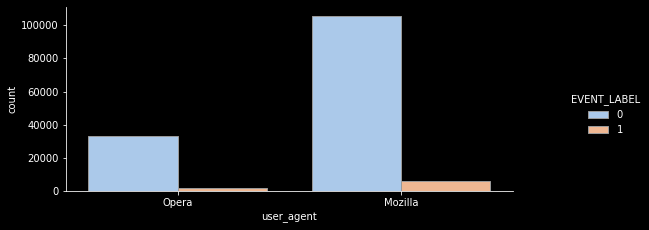

In [ ]:
#user agent(인터넷 블라우저 사용환경)에 따른 사기거래율 비교하기
# 두가지의 사용 환경이고 비율은 비슷한거 같음
sns.catplot(x='user_agent', hue='EVENT_LABEL', kind='count', palette='pastel',edgecolor='.6',data=df);
plt.gcf().set_size_inches(10,3)

In [ ]:
cat_val = 'user_agent'

df_tran = pd.DataFrame(df.groupby([cat_val , 'EVENT_LABEL'])['EVENT_TIMESTAMP'].count()).reset_index()#총 횟수를 셀수있는 카테고리를 이용한거 같음
df_tran.head()

df_pivot = pd.pivot_table(df_tran,
                        index=cat_val,
                        columns = 'EVENT_LABEL',
                        values = 'EVENT_TIMESTAMP')

df_pivot = df_pivot.reset_index()
df_pivot.columns.names = ['']

df_pivot['ratio'] = round((df_pivot.iloc[:,2]) / (df_pivot.iloc[:,1] + df_pivot.iloc[:,2])*100,1)
df_pivot

,user_agent,0,1,ratio
0,Mozilla,105492,6121,5.5
1,Opera,33504,1883,5.3


In [ ]:
df['currency'].value_counts()

cad    111543
usd     31151
eur      4306
Name: currency, dtype: int64

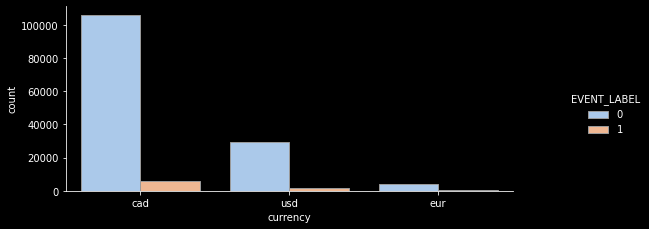

In [ ]:
#거래통화에 따른 사기거래율 비교
sns.catplot(x='currency', hue= 'EVENT_LABEL',kind='count',palette='pastel',edgecolor='.6',data=df);
plt.gcf().set_size_inches(10,3)

In [ ]:
cat_val='currency'

# ▶ 1단계
df_tran = pd.DataFrame(df.groupby([cat_val, 'EVENT_LABEL'])['EVENT_TIMESTAMP'].count()).reset_index()
df_tran.head(5)

# ▶ 2단계
df_pivot = pd.pivot_table(df_tran,                   # 피벗할 데이터프레임
                      index = cat_val,               # 행 위치에 들어갈 열
                      columns = 'EVENT_LABEL',       # 열 위치에 들어갈 열
                      values = 'EVENT_TIMESTAMP')    # 데이터로 사용할 열 
# ▶ 3단계
df_pivot = df_pivot.reset_index()
df_pivot.columns.names=['']

# ▶ 4단계
df_pivot['ratio'] =   round((df_pivot.iloc[:,2])/ (df_pivot.iloc[:,1]+df_pivot.iloc[:,2]) * 100,1)
df_pivot

,currency,0,1,ratio
0,cad,105869,5674,5.1
1,eur,3863,443,10.3
2,usd,29264,1887,6.1


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

X = df.drop(['EVENT_TIMESTAMP', 'EVENT_LABEL','transaction_amt_gp'],axis=1)
Y = df['EVENT_LABEL']
x_train, x_test,y_train,y_test=train_test_split(X,Y,test_size=0.3,stratify=Y)

In [ ]:
categoical_list.remove('EVENT_TIMESTAMP')

In [ ]:
print(categoical_list)

['ip_address', 'user_agent', 'email_domain', 'phone_number', 'billing_city', 'billing_state', 'currency', 'cvv', 'signature_image', 'transaction_type', 'transaction_env', 'applicant_name', 'billing_address', 'merchant_id', 'locale', 'tranaction_initiate']


In [ ]:
from sklearn.preprocessing import LabelEncoder

for col in categoical_list:
  print(col)
  le=LabelEncoder()
  le.fit(list(x_train[col].values) + list(x_test[col].values))
  x_train[col] = le.transform(x_train[col])
  x_test[col] = le.transform(x_test[col])

ip_address
user_agent
email_domain
phone_number
billing_city
billing_state
currency
cvv
signature_image
transaction_type
transaction_env
applicant_name
billing_address
merchant_id
locale
tranaction_initiate


In [ ]:
x_train[categoical_list].head(3)

,ip_address,user_agent,email_domain,phone_number,billing_city,billing_state,currency,cvv,signature_image,transaction_type,transaction_env,applicant_name,billing_address,merchant_id,locale,tranaction_initiate
135923,10292,0,370,6539,6066,13,0,6,13,17,3,47198,10890,86993,233,7
71510,2045,0,2143,5178,5319,21,0,6,23,7,5,16666,52186,138658,207,21
127298,6574,0,1295,12023,2924,28,0,8,1,8,3,43486,51189,32950,279,24


In [ ]:
x_test[categoical_list].head(3)

,ip_address,user_agent,email_domain,phone_number,billing_city,billing_state,currency,cvv,signature_image,transaction_type,transaction_env,applicant_name,billing_address,merchant_id,locale,tranaction_initiate
29850,8522,1,2776,6952,1558,0,0,22,3,6,8,22678,92807,43887,278,14
121062,8670,1,4634,3958,134,42,0,3,8,8,2,26707,124132,48194,225,9
88399,4929,0,1738,9118,7703,31,0,3,8,2,3,72308,125596,81931,284,22


In [ ]:
from sklearn.metrics import classification_report
rfc= RandomForestClassifier(random_state=123456,max_depth=8,n_estimators=500)
rfc.fit(x_train,y_train)

#예측
y_pred_train=rfc.predict(x_train)
y_pred_test=rfc.predict(x_test)

print(classification_report(y_train,y_pred_train))
print(classification_report(y_test,y_pred_test))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98     97297
           1       0.97      0.33      0.49      5603

    accuracy                           0.96    102900
   macro avg       0.97      0.66      0.74    102900
weighted avg       0.96      0.96      0.95    102900

              precision    recall  f1-score   support

           0       0.96      1.00      0.98     41699
           1       0.97      0.30      0.46      2401

    accuracy                           0.96     44100
   macro avg       0.97      0.65      0.72     44100
weighted avg       0.96      0.96      0.95     44100



In [ ]:
pd.Series(y_pred_test).value_counts()

0    43357
1      743
dtype: int64

In [ ]:
#ROC
#이진 분류기의 성능을 평가할때 사용하는 지표(metric),100에 가까울수록 모델 성능이 좋은것(다양한 treshold에 대한 이진 분류기의 성능을 한번에 표시한것)
#과적합 문제 Train과 test set에 성능을 최대한 줄여주는 것이 과적합을 방지
from sklearn.metrics import roc_auc_score

y_pred_train_proba = rfc.predict_proba(x_train)[:,1]
y_pred_test_proba = rfc.predict_proba(x_test)[:,1]

roc_score_train = roc_auc_score(y_train,y_pred_train_proba)
roc_score_test = roc_auc_score(y_test,y_pred_test_proba)

print("roc_score_train : {}".format(roc_score_train))
print("roc_score_test : {}".format(roc_score_test))


roc_score_train : 0.9462439029116578
roc_score_test : 0.9322621705531517


# 중요변수 파악

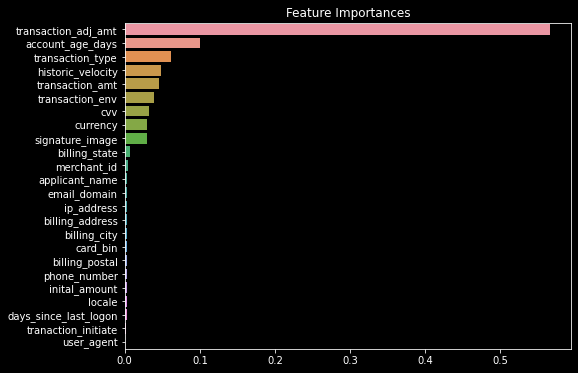

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use(['dark_background'])

ftr_importance_values = rfc.feature_importances_
ftr_importances = pd.Series(ftr_importance_values,index=x_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:30]

plt.figure(figsize = (8,6))
plt.title('Feature Importances')
sns.barplot(x=ftr_top20,y=ftr_top20.index)

plt.show()

확실히 금액에 따라 사기거래를 판별하는 것이 가장 핵심인것 같다

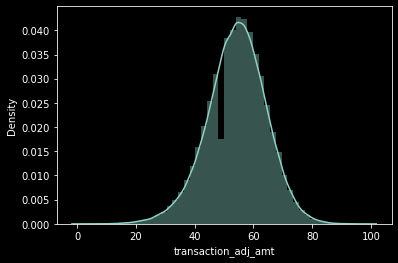

In [ ]:
# 1번 중요 변수에 대한 상세 탐색
sns.distplot(df['transaction_adj_amt']);

In [ ]:
# ▶ 구간화
import numpy as np
df['transaction_adj_amt_group'] = np.where (df['transaction_adj_amt'] <= 40, 1, 
                           np.where(df['transaction_adj_amt'] <= 60, 2, 3))

df[['transaction_adj_amt','transaction_adj_amt_group']]

,transaction_adj_amt,transaction_adj_amt_group
0,56.0,2
1,48.0,2
2,61.0,3
3,28.0,1
4,66.0,3
...,...,...
149995,57.0,2
149996,61.0,3
149997,48.0,2
149998,59.0,2


In [ ]:
df.groupby(['transaction_adj_amt_gp', 'EVENT_LABEL'])['EVENT_LABEL'].count()

KeyError: ignored

In [ ]:
# 조정된 금액이 작을수록 사기거래 확률이 급격시 상승한다. ( Critical한 변수임을 알수 있다.)
print("group1 :", (4628 / (4628+8072)) * 100)
print("group2 :", (3131 / (3131+92394)) * 100)
print("group3 :", (245 / (245+38530)) * 100)

In [ ]:
# 2번 중요 변수에 대한 상세 탐색
sns.distplot(df['account_age_days'])

In [ ]:
# ▶ 구간화
import numpy as np
df['account_age_days_group'] = np.where (df['account_age_days'] <= 3500, 1, 
                           np.where(df['account_age_days'] <= 4500, 2, 3))

df[['account_age_days','account_age_days_group']]

In [ ]:
df.groupby(['account_age_days_graph', 'EVENT_LABEL'])['EVENT_TIMESTAMP'].count()

In [ ]:
# 생성일이 오래 된 계좌일수록 사기거래률이 증가 눈에 확실하게 보임
print("group1 :", (190 / (24908+190)) * 100)
print("group2 :", (1087 / (1087+39636)) * 100)
print("group3 :", (6727 / (6727+74452)) * 100)

생성일이 좀 지난 계좌가 확실히 사기거래에 많이 이용되는거 같다

## 모델 Save and Read

In [ ]:
import pickle
# 모델 저장
saved_model = pickle.dumps(rfc)

# 모델 Read
clf_from_pickle = pickle.loads(saved_model)